This is a notebook behind this blog post:

   "A confidence interval can be empty"



In [1]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = 15.8, 7.9 # 15.8 is the maximum width in Jupyter
plt.style.use('fivethirtyeight') # 538 style

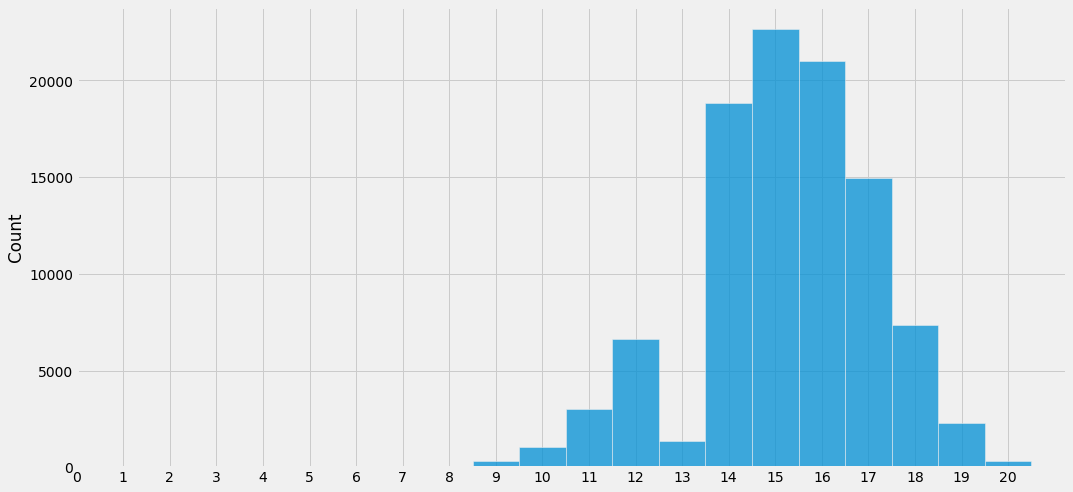

In [3]:
# Function to simulate the mechanism many times

def gen(g, m):
    # g is an integer between 0 and 20, inclusive
    #
    # repeat this 'm' times:
    #   - generate a binomial(n=20, p=g/20)
    #   - ..but if it's 13, then try again once.
    # 13 is possible, but unlikely, under this scheme 
    x = np.random.binomial(n=20, p=g/20, size=m)
    num_thirteens = (x==13).sum()
    replacements = np.random.binomial(n=20, p=g/20, size=num_thirteens)
    x[x==13] = replacements
    return x
    
x = gen(15, 100000)
sns.histplot(x, discrete=True)
plt.xticks(np.arange(0,20.5));

Next, I compute the probability mass function (pmf) of this analytically, and then plot it to ensure it's correct and it matches the histogram above:

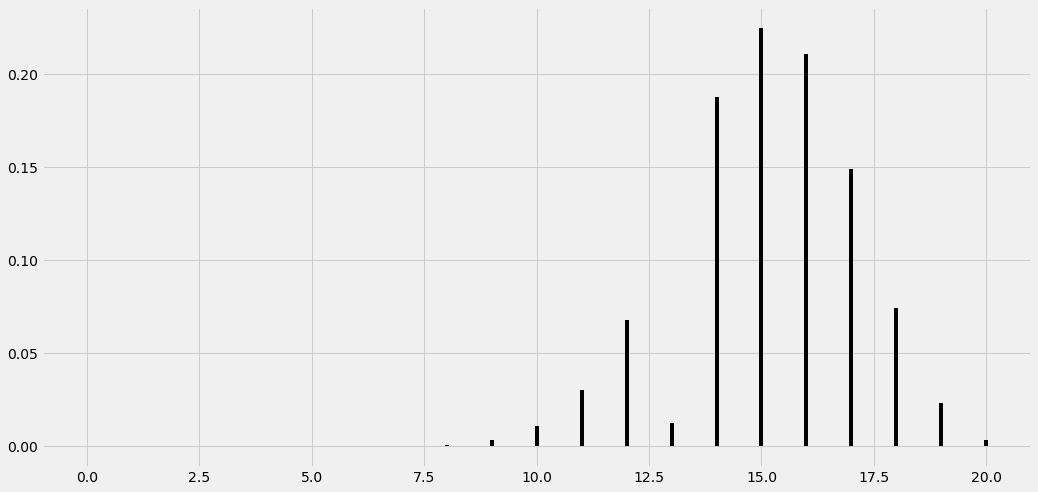

In [4]:
def pmf(g):
    # returns a vector of length 21, giving the probabilities of each of the 21 possible outcomes
    p13 = binom.pmf(13, n=20, p=g/20)
    # each number, other than 13, can occur two different ways: either directly, or after 13 is chosen the first time
    p = binom.pmf(k = np.arange(0,20.5), n=20, p=g/20) * (1+p13)
    p[13] = p13*p13
    assert 0.9999999 < p.sum() <= 1.0
    return p

plt.vlines(range(0,21), 0, pmf(15));

Next, a function to show the 21x21 table. Note how the sum of each row sums to 100%.
A 'interval-generating' function is specified via `f`, which takes two params `g` and `x`. It answers the question, based on the observed data `x`,  _"is `g` in the confidence interval?"_

We demo it with a simple function that says "when we observe `x`, we estimate the parameter as the set {x-1, x, x+1}"

In [5]:
def one_cell(g, x, f):
    m = pmf(g)[x]
    in_the_ci = f(g, x)
    text = f'{m:.0%}' if m >= 0.01 else '&nbsp;'
    if in_the_ci:
        text = '<div style="background-color:lightgreen">' + text + '</div>'
    return text

def details_of_one_CI_function(f):
    totals = [ sum(pmf(g)[x] for x in range(21) if f(g,x))
              for g in range(21)]
    return display(Markdown(f"""
|| {'|'.join(f"x={i}" for i in range(21))} | |coverage = {min(totals):.1%}|
|{"-|"*22} -|-|
""" + '\n'.join([
f'| **g={g}** | {"|".join([one_cell(g,x,f) for x in range(21)])} |  | _{total:.1%}_ |'
        for g, total in enumerate(totals)
])))
details_of_one_CI_function(f=lambda g, x: abs(g-x) < 2)


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 42.3%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **g=0** | <div style="background-color:lightgreen">100%</div>|<div style="background-color:lightgreen">&nbsp;</div>|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _100.0%_ |
| **g=1** | <div style="background-color:lightgreen">36%</div>|<div style="background-color:lightgreen">38%</div>|<div style="background-color:lightgreen">19%</div>|6%|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _92.5%_ |
| **g=2** | 12%|<div style="background-color:lightgreen">27%</div>|<div style="background-color:lightgreen">29%</div>|<div style="background-color:lightgreen">19%</div>|9%|3%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _74.5%_ |
| **g=3** | 4%|14%|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">24%</div>|<div style="background-color:lightgreen">18%</div>|10%|5%|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _65.4%_ |
| **g=4** | 1%|6%|14%|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">17%</div>|11%|5%|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _59.8%_ |
| **g=5** | &nbsp;|2%|7%|13%|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">17%</div>|11%|6%|3%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _56.1%_ |
| **g=6** | &nbsp;|&nbsp;|3%|7%|13%|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">16%</div>|11%|7%|3%|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _53.5%_ |
| **g=7** | &nbsp;|&nbsp;|1%|3%|7%|13%|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">16%</div>|12%|7%|3%|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _51.9%_ |
| **g=8** | &nbsp;|&nbsp;|&nbsp;|1%|4%|8%|13%|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">16%</div>|12%|7%|4%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _51.3%_ |
| **g=9** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|4%|8%|13%|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">17%</div>|12%|8%|&nbsp;|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _51.7%_ |
| **g=10** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|4%|8%|13%|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">17%</div>|13%|&nbsp;|4%|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _53.3%_ |
| **g=11** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|4%|8%|13%|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">18%</div>|1%|8%|4%|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _56.0%_ |
| **g=12** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|4%|8%|14%|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">3%</div>|15%|9%|4%|1%|&nbsp;|&nbsp;|&nbsp; |  | _42.3%_ |
| **g=13** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|4%|8%|14%|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">20%</div>|15%|9%|4%|1%|&nbsp;|&nbsp; |  | _42.8%_ |
| **g=14** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|4%|8%|13%|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">21%</div>|15%|8%|3%|&nbsp;|&nbsp; |  | _45.8%_ |
| **g=15** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|3%|7%|1%|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">21%</div>|15%|7%|2%|&nbsp; |  | _62.4%_ |
| **g=16** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|&nbsp;|12%|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">22%</div>|14%|6%|1% |  | _63.1%_ |
| **g=17** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|5%|10%|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">25%</div>|<div style="background-color:lightgreen">23%</div>|14%|4% |  | _66.5%_ |
| **g=18** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|3%|9%|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">29%</div>|<div style="background-color:lightgreen">27%</div>|12% |  | _74.7%_ |
| **g=19** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|6%|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">38%</div>|<div style="background-color:lightgreen">36%</div> |  | _92.5%_ |
| **g=20** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">100%</div> |  | _100.0%_ |

In [6]:
details_of_one_CI_function(f=lambda g, x: False)


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 0.0%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **g=0** | 100%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=1** | 36%|38%|19%|6%|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=2** | 12%|27%|29%|19%|9%|3%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=3** | 4%|14%|23%|24%|18%|10%|5%|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=4** | 1%|6%|14%|21%|22%|17%|11%|5%|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=5** | &nbsp;|2%|7%|13%|19%|20%|17%|11%|6%|3%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=6** | &nbsp;|&nbsp;|3%|7%|13%|18%|19%|16%|11%|7%|3%|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=7** | &nbsp;|&nbsp;|1%|3%|7%|13%|17%|19%|16%|12%|7%|3%|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=8** | &nbsp;|&nbsp;|&nbsp;|1%|4%|8%|13%|17%|18%|16%|12%|7%|4%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=9** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|4%|8%|13%|17%|18%|17%|12%|8%|&nbsp;|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=10** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|4%|8%|13%|17%|19%|17%|13%|&nbsp;|4%|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=11** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|4%|8%|13%|18%|20%|18%|1%|8%|4%|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=12** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|4%|8%|14%|19%|21%|3%|15%|9%|4%|1%|&nbsp;|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=13** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|4%|8%|14%|19%|3%|20%|15%|9%|4%|1%|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=14** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|4%|8%|13%|3%|22%|21%|15%|8%|3%|&nbsp;|&nbsp; |  | _0.0%_ |
| **g=15** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|3%|7%|1%|19%|23%|21%|15%|7%|2%|&nbsp; |  | _0.0%_ |
| **g=16** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|&nbsp;|12%|18%|23%|22%|14%|6%|1% |  | _0.0%_ |
| **g=17** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|5%|10%|19%|25%|23%|14%|4% |  | _0.0%_ |
| **g=18** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|3%|9%|19%|29%|27%|12% |  | _0.0%_ |
| **g=19** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|6%|19%|38%|36% |  | _0.0%_ |
| **g=20** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|100% |  | _0.0%_ |

In [7]:
details_of_one_CI_function(f=lambda g, x: True)


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 100.0%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **g=0** | <div style="background-color:lightgreen">100%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=1** | <div style="background-color:lightgreen">36%</div>|<div style="background-color:lightgreen">38%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">6%</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=2** | <div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">27%</div>|<div style="background-color:lightgreen">29%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">9%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=3** | <div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">24%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">10%</div>|<div style="background-color:lightgreen">5%</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=4** | <div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">6%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">11%</div>|<div style="background-color:lightgreen">5%</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=5** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">11%</div>|<div style="background-color:lightgreen">6%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=6** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">16%</div>|<div style="background-color:lightgreen">11%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=7** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">16%</div>|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=8** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">16%</div>|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=9** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=10** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=11** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=12** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">9%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=13** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">9%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=14** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=15** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">&nbsp;</div> |  | _100.0%_ |
| **g=16** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">6%</div>|<div style="background-color:lightgreen">1%</div> |  | _100.0%_ |
| **g=17** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">5%</div>|<div style="background-color:lightgreen">10%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">25%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">4%</div> |  | _100.0%_ |
| **g=18** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">9%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">29%</div>|<div style="background-color:lightgreen">27%</div>|<div style="background-color:lightgreen">12%</div> |  | _100.0%_ |
| **g=19** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">1%</div>|<div style="background-color:lightgreen">6%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">38%</div>|<div style="background-color:lightgreen">36%</div> |  | _100.0%_ |
| **g=20** | <div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">&nbsp;</div>|<div style="background-color:lightgreen">100%</div> |  | _100.0%_ |

In [8]:
def given_g_and_coverage__the_smallest_set(g, coverage):
    if coverage == 0:
        return set()
    pmfs = [ (pmf(g)[x], x) for x in range(21) ]
    mode_to_lowest = sorted(pmfs, reverse=True)
    del pmfs
    size = 1 + (np.cumsum([m for m, _ in mode_to_lowest]) < coverage).sum()
    smallest_set = mode_to_lowest[:size]
    assert (coverage-1e-5) <= sum(m for m, _ in smallest_set) <= 1.0
    return set(x for _, x in smallest_set)

given_g_and_coverage__the_smallest_set(1, .95)

{0, 1, 2, 3}

In [9]:
def best_ci(coverage):
    map_of_smallest = { g: given_g_and_coverage__the_smallest_set(g, coverage) for g in range(21) }
    def go(g, x):
        return x in map_of_smallest[g]
        return abs(g-x) < 3
    return go

In [10]:
details_of_one_CI_function(f=best_ci(0.95))


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 95.0%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **g=0** | <div style="background-color:lightgreen">100%</div>|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _100.0%_ |
| **g=1** | <div style="background-color:lightgreen">36%</div>|<div style="background-color:lightgreen">38%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">6%</div>|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _98.4%_ |
| **g=2** | <div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">27%</div>|<div style="background-color:lightgreen">29%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">9%</div>|3%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _95.7%_ |
| **g=3** | <div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">24%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">10%</div>|<div style="background-color:lightgreen">5%</div>|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _97.8%_ |
| **g=4** | 1%|<div style="background-color:lightgreen">6%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">11%</div>|<div style="background-color:lightgreen">5%</div>|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _95.6%_ |
| **g=5** | &nbsp;|2%|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">11%</div>|<div style="background-color:lightgreen">6%</div>|<div style="background-color:lightgreen">3%</div>|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _96.2%_ |
| **g=6** | &nbsp;|&nbsp;|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">16%</div>|<div style="background-color:lightgreen">11%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">3%</div>|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _97.6%_ |
| **g=7** | &nbsp;|&nbsp;|1%|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">16%</div>|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">3%</div>|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _97.3%_ |
| **g=8** | &nbsp;|&nbsp;|&nbsp;|1%|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">16%</div>|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">4%</div>|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _97.7%_ |
| **g=9** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">8%</div>|&nbsp;|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _95.7%_ |
| **g=10** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">13%</div>|&nbsp;|<div style="background-color:lightgreen">4%</div>|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _95.0%_ |
| **g=11** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|<div style="background-color:lightgreen">2%</div>|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">18%</div>|1%|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">4%</div>|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _95.7%_ |
| **g=12** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">9%</div>|<div style="background-color:lightgreen">4%</div>|1%|&nbsp;|&nbsp;|&nbsp; |  | _95.7%_ |
| **g=13** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">9%</div>|<div style="background-color:lightgreen">4%</div>|1%|&nbsp;|&nbsp; |  | _96.2%_ |
| **g=14** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">3%</div>|&nbsp;|&nbsp; |  | _97.1%_ |
| **g=15** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|<div style="background-color:lightgreen">3%</div>|<div style="background-color:lightgreen">7%</div>|1%|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">2%</div>|&nbsp; |  | _96.8%_ |
| **g=16** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|&nbsp;|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">6%</div>|1% |  | _95.1%_ |
| **g=17** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|<div style="background-color:lightgreen">5%</div>|<div style="background-color:lightgreen">10%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">25%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">14%</div>|4% |  | _95.4%_ |
| **g=18** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|3%|<div style="background-color:lightgreen">9%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">29%</div>|<div style="background-color:lightgreen">27%</div>|<div style="background-color:lightgreen">12%</div> |  | _95.9%_ |
| **g=19** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|<div style="background-color:lightgreen">6%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">38%</div>|<div style="background-color:lightgreen">36%</div> |  | _98.4%_ |
| **g=20** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|<div style="background-color:lightgreen">100%</div> |  | _100.0%_ |

In [11]:
details_of_one_CI_function(f=best_ci(0.90))


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 90.2%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **g=0** | <div style="background-color:lightgreen">100%</div>|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _100.0%_ |
| **g=1** | <div style="background-color:lightgreen">36%</div>|<div style="background-color:lightgreen">38%</div>|<div style="background-color:lightgreen">19%</div>|6%|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _92.5%_ |
| **g=2** | <div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">27%</div>|<div style="background-color:lightgreen">29%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">9%</div>|3%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _95.7%_ |
| **g=3** | 4%|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">24%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">10%</div>|<div style="background-color:lightgreen">5%</div>|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _93.9%_ |
| **g=4** | 1%|<div style="background-color:lightgreen">6%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">11%</div>|5%|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _90.2%_ |
| **g=5** | &nbsp;|2%|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">11%</div>|<div style="background-color:lightgreen">6%</div>|3%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _93.5%_ |
| **g=6** | &nbsp;|&nbsp;|3%|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">16%</div>|<div style="background-color:lightgreen">11%</div>|<div style="background-color:lightgreen">7%</div>|3%|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _91.7%_ |
| **g=7** | &nbsp;|&nbsp;|1%|3%|<div style="background-color:lightgreen">7%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">16%</div>|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">7%</div>|3%|1%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _90.7%_ |
| **g=8** | &nbsp;|&nbsp;|&nbsp;|1%|4%|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">16%</div>|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">7%</div>|4%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _90.6%_ |
| **g=9** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|4%|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">8%</div>|&nbsp;|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _91.9%_ |
| **g=10** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|4%|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">17%</div>|<div style="background-color:lightgreen">13%</div>|&nbsp;|<div style="background-color:lightgreen">4%</div>|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _91.0%_ |
| **g=11** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">18%</div>|1%|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">4%</div>|2%|&nbsp;|&nbsp;|&nbsp;|&nbsp; |  | _94.0%_ |
| **g=12** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">21%</div>|3%|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">9%</div>|<div style="background-color:lightgreen">4%</div>|1%|&nbsp;|&nbsp;|&nbsp; |  | _92.9%_ |
| **g=13** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">19%</div>|3%|<div style="background-color:lightgreen">20%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">9%</div>|<div style="background-color:lightgreen">4%</div>|1%|&nbsp;|&nbsp; |  | _92.8%_ |
| **g=14** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|<div style="background-color:lightgreen">4%</div>|<div style="background-color:lightgreen">8%</div>|<div style="background-color:lightgreen">13%</div>|3%|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">8%</div>|3%|&nbsp;|&nbsp; |  | _91.2%_ |
| **g=15** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|3%|<div style="background-color:lightgreen">7%</div>|1%|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">21%</div>|<div style="background-color:lightgreen">15%</div>|<div style="background-color:lightgreen">7%</div>|2%|&nbsp; |  | _91.5%_ |
| **g=16** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|2%|&nbsp;|<div style="background-color:lightgreen">12%</div>|<div style="background-color:lightgreen">18%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">22%</div>|<div style="background-color:lightgreen">14%</div>|<div style="background-color:lightgreen">6%</div>|1% |  | _95.1%_ |
| **g=17** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|5%|<div style="background-color:lightgreen">10%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">25%</div>|<div style="background-color:lightgreen">23%</div>|<div style="background-color:lightgreen">14%</div>|4% |  | _90.8%_ |
| **g=18** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|3%|<div style="background-color:lightgreen">9%</div>|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">29%</div>|<div style="background-color:lightgreen">27%</div>|<div style="background-color:lightgreen">12%</div> |  | _95.9%_ |
| **g=19** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|1%|6%|<div style="background-color:lightgreen">19%</div>|<div style="background-color:lightgreen">38%</div>|<div style="background-color:lightgreen">36%</div> |  | _92.5%_ |
| **g=20** | &nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|<div style="background-color:lightgreen">100%</div> |  | _100.0%_ |